**Sprint-3_Add Layers, Traing and Test Models**

# **Data Collection**

In [227]:
import numpy as np 
import pandas as pd 
import datetime
from pylab import rcParams
import matplotlib.pyplot as plt
import warnings
import itertools
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm

In [228]:
df=pd.read_csv("Crude Oil Prices Daily.csv")

In [229]:
df.head()

,Date,Price
0,2-Jan-86,25.56
1,3-Jan-86,26.00
2,6-Jan-86,26.53
3,7-Jan-86,25.85
4,8-Jan-86,25.87


In [230]:
df['Date'] = pd.to_datetime(df['Date'])

# **Data Preprocessing**

In [231]:
df = df.sort_values('Date')
df = df.groupby('Date')['Price'].sum().reset_index()
df.set_index('Date', inplace=True)

In [232]:
def DfInfo(df_initial):
    # gives some infos on columns types and numer of null values
    tab_info = pd.DataFrame(df_initial.dtypes).T.rename(index={0: 'column type'})
    tab_info = tab_info.append(pd.DataFrame(df_initial.isnull().sum()).T.rename(index={0: 'null values (nb)'}))
    tab_info = tab_info.append(pd.DataFrame(df_initial.isnull().sum() / df_initial.shape[0] * 100).T.
                               rename(index={0: 'null values (%)'}))
    return tab_info

In [233]:
DfInfo(df)

,Price
column type,float64
null values (nb),0
null values (%),0.0


In [181]:
df.index

DatetimeIndex(['1986-01-02', '1986-01-03', '1986-01-06', '1986-01-07',
               '1986-01-08', '1986-01-09', '1986-01-10', '1986-01-13',
               '1986-01-14', '1986-01-15',
               ...
               '2022-10-18', '2022-10-19', '2022-10-20', '2022-10-21',
               '2022-10-24', '2022-10-25', '2022-10-26', '2022-10-27',
               '2022-10-28', '2022-10-31'],
              dtype='datetime64[ns]', name='Date', length=9281, freq=None)

# **Data  Visualization**

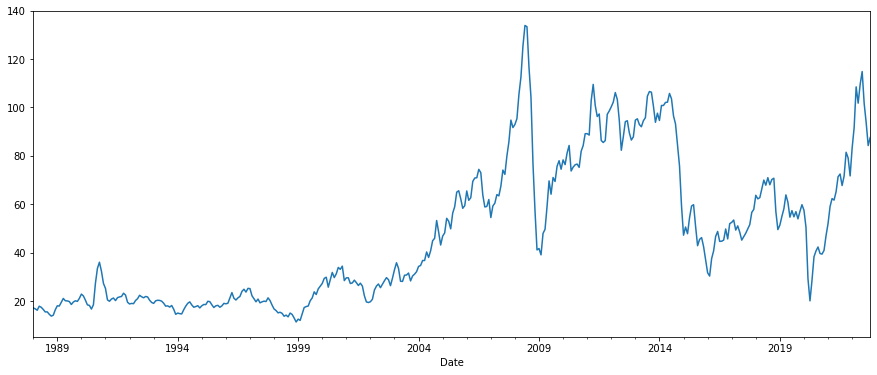

In [219]:
df1 = df
df1 = df1.sort_values('Date')
df1 = df1.groupby('Date')['Price'].sum().reset_index()
df1.set_index('Date', inplace=True)
df1=df1.loc[datetime.date(year=1988,month=1,day=1):]
q = df1['Price'].resample('MS').mean()
q.plot(figsize=(15, 6))
plt.show()

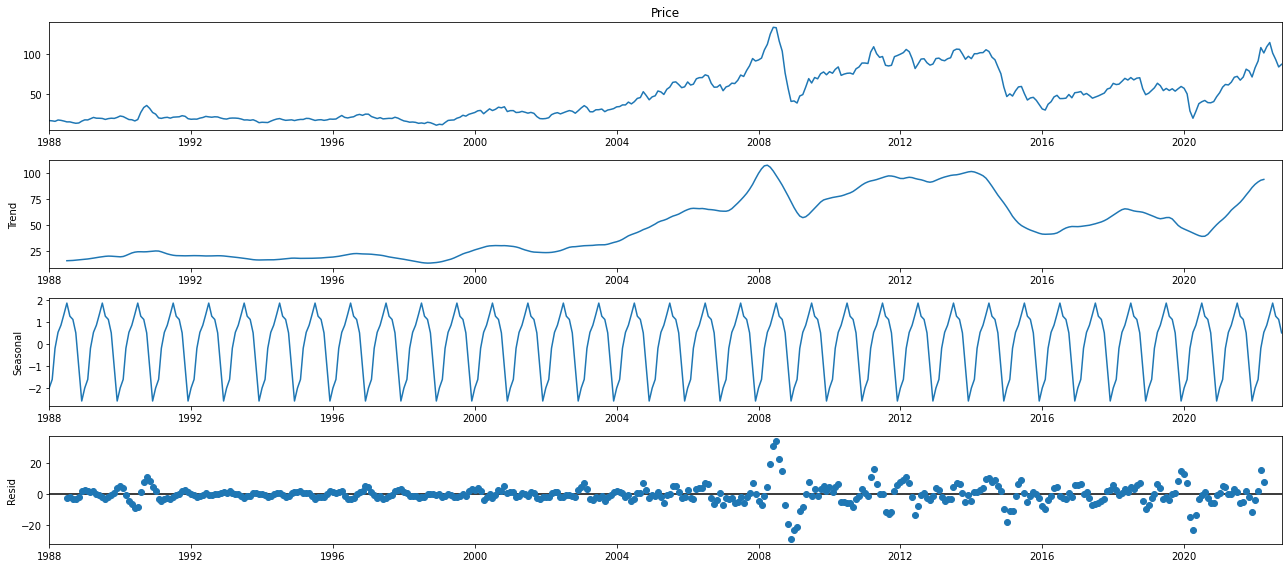

In [221]:
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(q, model='additive')
fig = decomposition.plot()
plt.show()

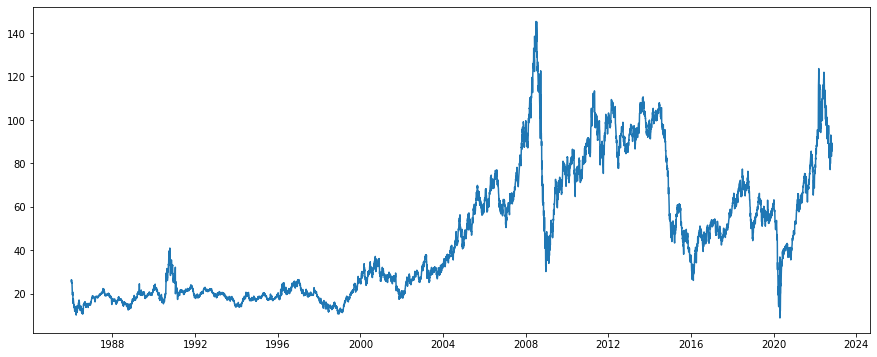

In [220]:
plt_1 = plt.figure(figsize=(15, 6))
time = pd.to_datetime(df['Date'])
data = list(df['Price'])
copdata = pd.Series(data, time)
plt.plot(copdata)

# **Scaling**

In [234]:
scaler = MinMaxScaler(feature_range = (0, 1))
df = scaler.fit_transform(df)

In [183]:
import joblib
joblib.dump(scaler, 'scaler.save')

['scaler.save']

# **Split Data Into Train/Test**

In [185]:
train_size = int(len(df) * 0.70)
test_size = len(df) - train_size
train, test = df[0:train_size, :], df[train_size:len(df), :]

# **Sliding Window**

In [184]:
def create_data_set(_data_set, _look_back=1):
    data_x, data_y = [], []
    for i in range(len(_data_set) - _look_back - 1):
        a = _data_set[i:(i + _look_back), 0]
        data_x.append(a)
        data_y.append(_data_set[i + _look_back, 0])
    return np.array(data_x), np.array(data_y)

In [186]:
look_back=10
x_train,y_train,x_test,y_test = [],[],[],[]
x_train,y_train=create_data_set(train,look_back)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test,y_test=create_data_set(test,look_back)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [187]:
print(x_test.shape[1])

10


In [188]:
print(x_train.shape), print(y_train.shape)

(6485, 10, 1)
(6485,)


(None, None)

In [189]:
print(x_test.shape), print(y_test.shape)

(2774, 10, 1)
(2774,)


(None, None)

In [222]:
len(test)

2785

# **Importing The Model Building Libraries**

In [191]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from sklearn.metrics import mean_squared_error
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import seaborn as sns

# **Add Layers**

In [223]:
#Initializing The Model
regressor = Sequential()

#Adding LSTM Layers
regressor.add(LSTM(units = 60, return_sequences = True, input_shape = (x_train.shape[1], 1)))
regressor.add(Dropout(0.1))

regressor.add(LSTM(units = 60, return_sequences = True))
regressor.add(Dropout(0.1))

regressor.add(LSTM(units = 60))
regressor.add(Dropout(0.1))

#Adding Output Layers
regressor.add(Dense(units = 1))


# **Configure The Learning Process**

In [193]:
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
reduce_lr = ReduceLROnPlateau(monitor='val_loss',patience=5)

# **Train The Model**

In [194]:
history =regressor.fit(x_train, y_train, epochs = 20, batch_size = 64,validation_data=(x_test, y_test), callbacks=[reduce_lr],shuffle=False)

Epoch 1/20
102/102 [==============================] - 11s 45ms/step - loss: 0.0035 - val_loss: 0.0340 - lr: 0.0010
Epoch 2/20
102/102 [==============================] - 3s 31ms/step - loss: 0.0102 - val_loss: 0.0058 - lr: 0.0010
Epoch 3/20
102/102 [==============================] - 3s 32ms/step - loss: 0.0020 - val_loss: 5.8901e-04 - lr: 0.0010
Epoch 4/20
102/102 [==============================] - 3s 31ms/step - loss: 6.6277e-04 - val_loss: 7.4892e-04 - lr: 0.0010
Epoch 5/20
102/102 [==============================] - 3s 31ms/step - loss: 6.5273e-04 - val_loss: 7.2144e-04 - lr: 0.0010
Epoch 6/20
102/102 [==============================] - 4s 42ms/step - loss: 6.8250e-04 - val_loss: 7.7041e-04 - lr: 0.0010
Epoch 7/20
102/102 [==============================] - 3s 32ms/step - loss: 6.3582e-04 - val_loss: 0.0011 - lr: 0.0010
Epoch 8/20
102/102 [==============================] - 3s 32ms/step - loss: 0.0014 - val_loss: 0.0029 - lr: 0.0010
Epoch 9/20
102/102 [==============================] - 3

# **Save Model**

In [195]:
regressor.save('model1.h5')

# **Model Evaluation**

In [196]:
train_predict = regressor.predict(x_train)
test_predict = regressor.predict(x_test)

87/87 [==============================] - 1s 7ms/step


In [197]:
train_predict = scaler.inverse_transform(train_predict)
y_train = scaler.inverse_transform([y_train])
test_predict = scaler.inverse_transform(test_predict)
y_test = scaler.inverse_transform([y_test])

Train Mean Absolute Error: 1.4024590247631437
Train Root Mean Squared Error: 2.2786515014985467
Test Mean Absolute Error: 2.320371915752628
Test Root Mean Squared Error: 3.1758979475815634


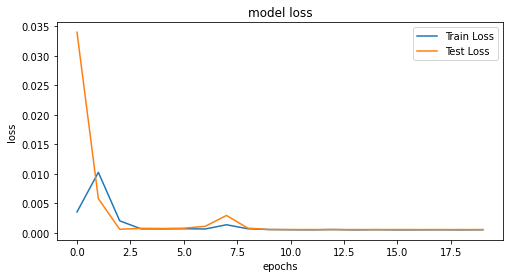

In [198]:
print('Train Mean Absolute Error:', mean_absolute_error(y_train[0], train_predict[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(y_train[0], train_predict[:,0])))
print('Test Mean Absolute Error:', mean_absolute_error(y_test[0], test_predict[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(y_test[0], test_predict[:,0])))
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

# **Test The Model**

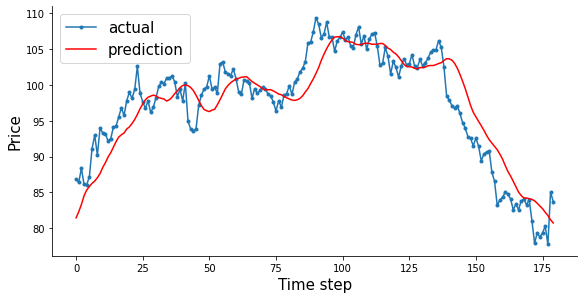

In [199]:
aa=[x for x in range(180)]
plt.figure(figsize=(8,4))
plt.plot(aa, y_test[0][:180], marker='.', label="actual")
plt.plot(aa, test_predict[:,0][:180], 'r', label="prediction")
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Price', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();

In [200]:
from keras.models import load_model
model=load_model('model1.h5')
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_15 (LSTM)              (None, 10, 60)            14880     
                                                                 
 dropout_15 (Dropout)        (None, 10, 60)            0         
                                                                 
 lstm_16 (LSTM)              (None, 10, 60)            29040     
                                                                 
 dropout_16 (Dropout)        (None, 10, 60)            0         
                                                                 
 lstm_17 (LSTM)              (None, 60)                29040     
                                                                 
 dropout_17 (Dropout)        (None, 60)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                

In [210]:
#Enter Last 10 Days Price:
string = '2,0,13,86,60,76,30,11,55,66'
string = string.split(',')
x_input = [eval(i) for i in string]    
sc = joblib.load("scaler.save") 
x_input = sc.fit_transform(np.array(x_input).reshape(-1,1))
x_input = x_input.reshape((1,10,1))
print(x_input.shape)

(1, 10, 1)


In [224]:
x_input

array([[[0.02325581],
        [0.        ],
        [0.15116279],
        [1.        ],
        [0.69767442],
        [0.88372093],
        [0.34883721],
        [0.12790698],
        [0.63953488],
        [0.76744186]]])

In [208]:
res = model.predict(x_input)

1/1 [==============================] - 0s 24ms/step


In [213]:
print('PRICE: ',res[0][0]*100)

PRICE:  36.834144592285156


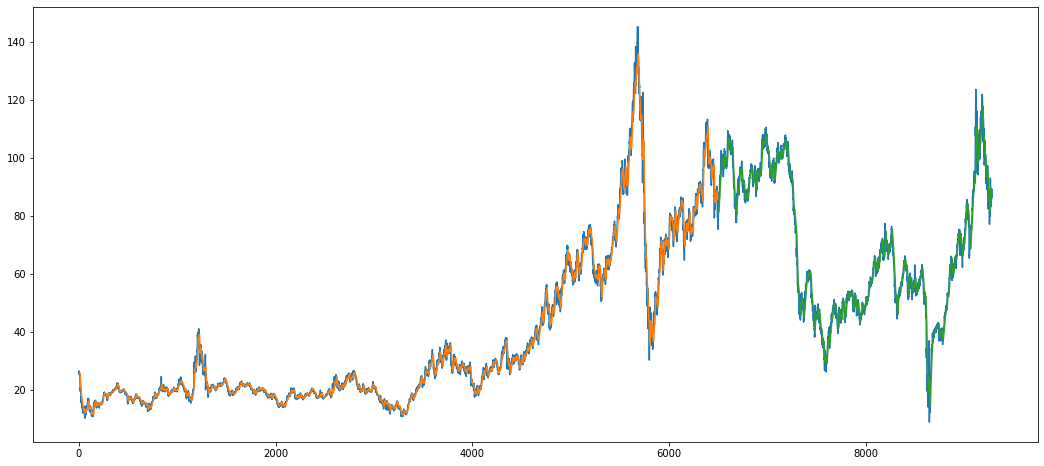

In [245]:
#test the model
look_back = 10
trainPredictPlot = np.empty_like(df)
trainPredictPlot[:,:] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back,:] = train_predict

testPredictPlot = np.empty_like(df)
testPredictPlot[:,:] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df)-1,:] = test_predict

plt.plot(scaler.inverse_transform(df))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()